# 1 - Fonctions de Preprocessing

L'installation du package "contractions" peut poser problème. En particulier, "!pip install contractions" n'a pas fonctionné ici (l'installation conjointe du package pyahocorasick posant problème).

La solution qui a fonctionné est la suivante : dans le terminal Anaconda Prompt, effectuer l'installation de pyahocorasick via "pip install pyahocorasick", puis installer contractions via "pip install contractions".


In [1]:
#!pip install wordcloud
#!pip install contractions
#!pip install pickle5
#import pickle5 as pickle

import os
import re
import tempfile
import time
import zipfile
import contractions
import nltk
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from wordcloud import WordCloud
from IPython import get_ipython
from IPython.display import display
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from urllib.request import urlopen

pd.set_option('max_colwidth', 400)

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def get_wordnet_pos(tag):
    """Fonction qui associe une classe à chaque mot"""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [3]:
NEGATION_SET = {'no', 'not'}

In [4]:
def negate_sequence(word_list):
    """Fonction qui lie un mot négatif (no ou not) au mot auquel il s'applique"""
    if len(word_list) > 1:
        if word_list[0] in NEGATION_SET:
            return [f"not_{word_list[1]}"] + negate_sequence(word_list[2:])
        else:
            return [word_list[0]] + negate_sequence(word_list[1:])
    else:
        return word_list

In [5]:
word_list = ["I", "am", "not", "young", "but", "not", "not", "old", "either"]
negate_sequence(word_list)

['I', 'am', 'not_young', 'but', 'not_not', 'old', 'either']

In [6]:
def text_preprocessing(serie, stop_words, lemmatization, negation):
    """
    Fonction qui réalise toutes les opérations appliquées au texte au cours de la phase de preprocessing
    stop_words, lemmatization et negation sont des paramètres booléens, qui permettent de choisir si l'on 
    applique les fonctions pareillement nommées au texte.
    """
    
    # passage en minuscule
    serie = serie.map(lambda x: x.lower())   

    # suppression des sauts de lignes et des retours à la ligne
    serie = serie.map(lambda x: re.sub(r'[\r|\n|\r\n]+', ' ', x))

    # suppression des @tag
    serie = serie.map(lambda x: re.sub(r'@[\S]+', '', x))

    # suppression de l'URL
    serie = serie.map(lambda x: re.sub('https?://[\S]+', '', x))
    
    # réécriture des contractions ( I'm -> i am)
    serie = serie.map(lambda x: contractions.fix(x).lower())
    
    # suppression des hashtags et des nombres
    serie = serie.map(lambda x: re.sub("[^a-zA-Z]", " ", x))

    # tokenisation
    serie = serie.map(word_tokenize)

    if stop_words:        
        # suppression des mots vides ( i like reading, so i read -> like reading read)
        stop_words = set(stopwords.words('english')).difference(NEGATION_SET)
        serie = serie.map(lambda x: [word for word in x if word not in stop_words])
    
    if lemmatization:
        # lemmatisation, simplification des mots ( feet -> foot)    
        serie = serie.map(nltk.tag.pos_tag)
        serie = serie.map(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
        wordnet_lemmatizer = WordNetLemmatizer()
        serie = serie.map(lambda x: [wordnet_lemmatizer.lemmatize(word, tag) for (word, tag) in x])
    
    if negation:
        serie = serie.map(lambda x: negate_sequence(x))

    serie = serie.map(lambda x: ' '.join(word for word in x))

    return serie

In [7]:
text = "i don't like it. this was aweful. this movie should definitely not be seen by children."
for stop_words in [False, True]:
    for lemmatization in [False, True]:
        for negation in [False, True]:
            print(text_preprocessing(pd.Series([text]), stop_words=stop_words, lemmatization=lemmatization, negation=negation))

0    i do not like it this was aweful this movie should definitely not be seen by children
dtype: object
0    i do not_like it this was aweful this movie should definitely not_be seen by children
dtype: object
0    i do not like it this be aweful this movie should definitely not be see by child
dtype: object
0    i do not_like it this be aweful this movie should definitely not_be see by child
dtype: object
0    not like aweful movie definitely not seen children
dtype: object
0    not_like aweful movie definitely not_seen children
dtype: object
0    not like aweful movie definitely not see child
dtype: object
0    not_like aweful movie definitely not_see child
dtype: object


# 2 - Base Sentiment140

## 2.1 - Récupération de la base Sentiment140

In [8]:
url, destname = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip', 'sentiment140'
temporary_location = "temp"

def download_unzip(url, dirname=tempfile.gettempdir(), destname="file"):
    myfile = requests.get(url)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    open(os.path.join(dirname, destname + '.zip'), 'wb').write(myfile.content)
    with zipfile.ZipFile(os.path.join(dirname, destname + '.zip'), 'r') as zip_ref:
        zip_ref.extractall(os.path.join(dirname, destname))

In [9]:
download_unzip(url, dirname=temporary_location, destname=destname)

In [10]:
trainfile = os.path.join(temporary_location, destname, "training.1600000.processed.noemoticon.csv")

columns = ['sentiment', 'id', 'date', 'query_string', 'user', 'text']

In [11]:
df = pd.read_csv(trainfile, header=None, names=columns, encoding='latin-1')

df.head(20)

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


# 2.2 - Preprocessing de la base Sentiment 140

Ce code n'a été (et ne doit être) éxécuté qu'une seule fois, pour construire et sauvegarder les différents états de la base 
Sentiment 140, selon que les fonctions stop_words, lemmatization et negation lui ont été appliquées ou non.

Si toutefois il fallait éxécuter à nouveau ce code, il faudrait alors faire attention à bien spécifier "l'endroit où les fichiers créés doivent être sauvegardés", en modifiant la variable path.

In [ ]:
for stop_words in [False, True]:
    for lemmatization in [False, True]:
        for negation in [False, True]:
            dfcopy = df.copy()
            a = time.time()
            dfcopy.text = text_preprocessing(dfcopy.text, stop_words=stop_words, lemmatization=lemmatization, negation=negation)
            dfcopy = dfcopy[dfcopy.text != '']

            print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}, time: {time.time() - a}")
            display(dfcopy[['text']].head(10))

            file = "train"  #Le nom du fichier créé dépend des fonctions (stop_words, lemmatization, negation) qui ont été appliquées à la base Sentiment 140
            if stop_words:
                file += "_stop"
            if lemmatization:
                file += "_lemm"
            if negation:
                file += "_neg"
            
            path = "C:/Users/Utilisateur/Desktop/ENSAE/2A/Projet Python/Python_2A/data/Sentiment140csv"
            dfcopy.to_csv(os.path.join(path, file+".csv")) #Création du fichier à l'adresse souhaitée
            #Le code est écrit de telle sorte qu'un fichier csv soit créé
            #En pratique, un code similaire a été utilisé pour créer des fichiers .bz2, avec pickle
            #car les fichiers .csv étaient trop lourds pour être uploadés sur GitHub

# 3 - Base webscrapée

## 3.1 - Récupération de la base webscrapée

In [12]:
tweets_df = pd.read_csv(os.path.join("data", "webcsv", "web.csv")).drop(columns=["Unnamed: 0", "Unnamed: 0.1"]) #pickle.load(pickle_file)


## 3.2 - Visualisation avant préprocessing

In [13]:
tweets_df.head(2)

,Film,Time Range,Text,Datetime,Tweet Id,Language
0,dune,"['2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23']","I wanna see Dune but the lack of Muslim and MENA actors when the novel supposedly references the middle-east and Islam is.... disappointing. Would have been a real good bit of representation for once, especially in a big Hollywood movie",2020-09-09 23:59:53+00:00,1303845614120304641,en
1,dune,"['2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23']",I might be the only person that knows fuckall about Dune but damn that trailer looks great and I love Denis Villenueve. That dude hasn't made a bad movie that I've seen and I've seen almost all of them.,2020-09-09 23:59:48+00:00,1303845592548941824,en


In [14]:
tweets_df_dune = tweets_df[tweets_df['Film'] == 'dune']
tweets_df_space_jam = tweets_df[tweets_df['Film'] == 'space jam']

On réalise un wordcloud pour les tweets concernant le film Dune

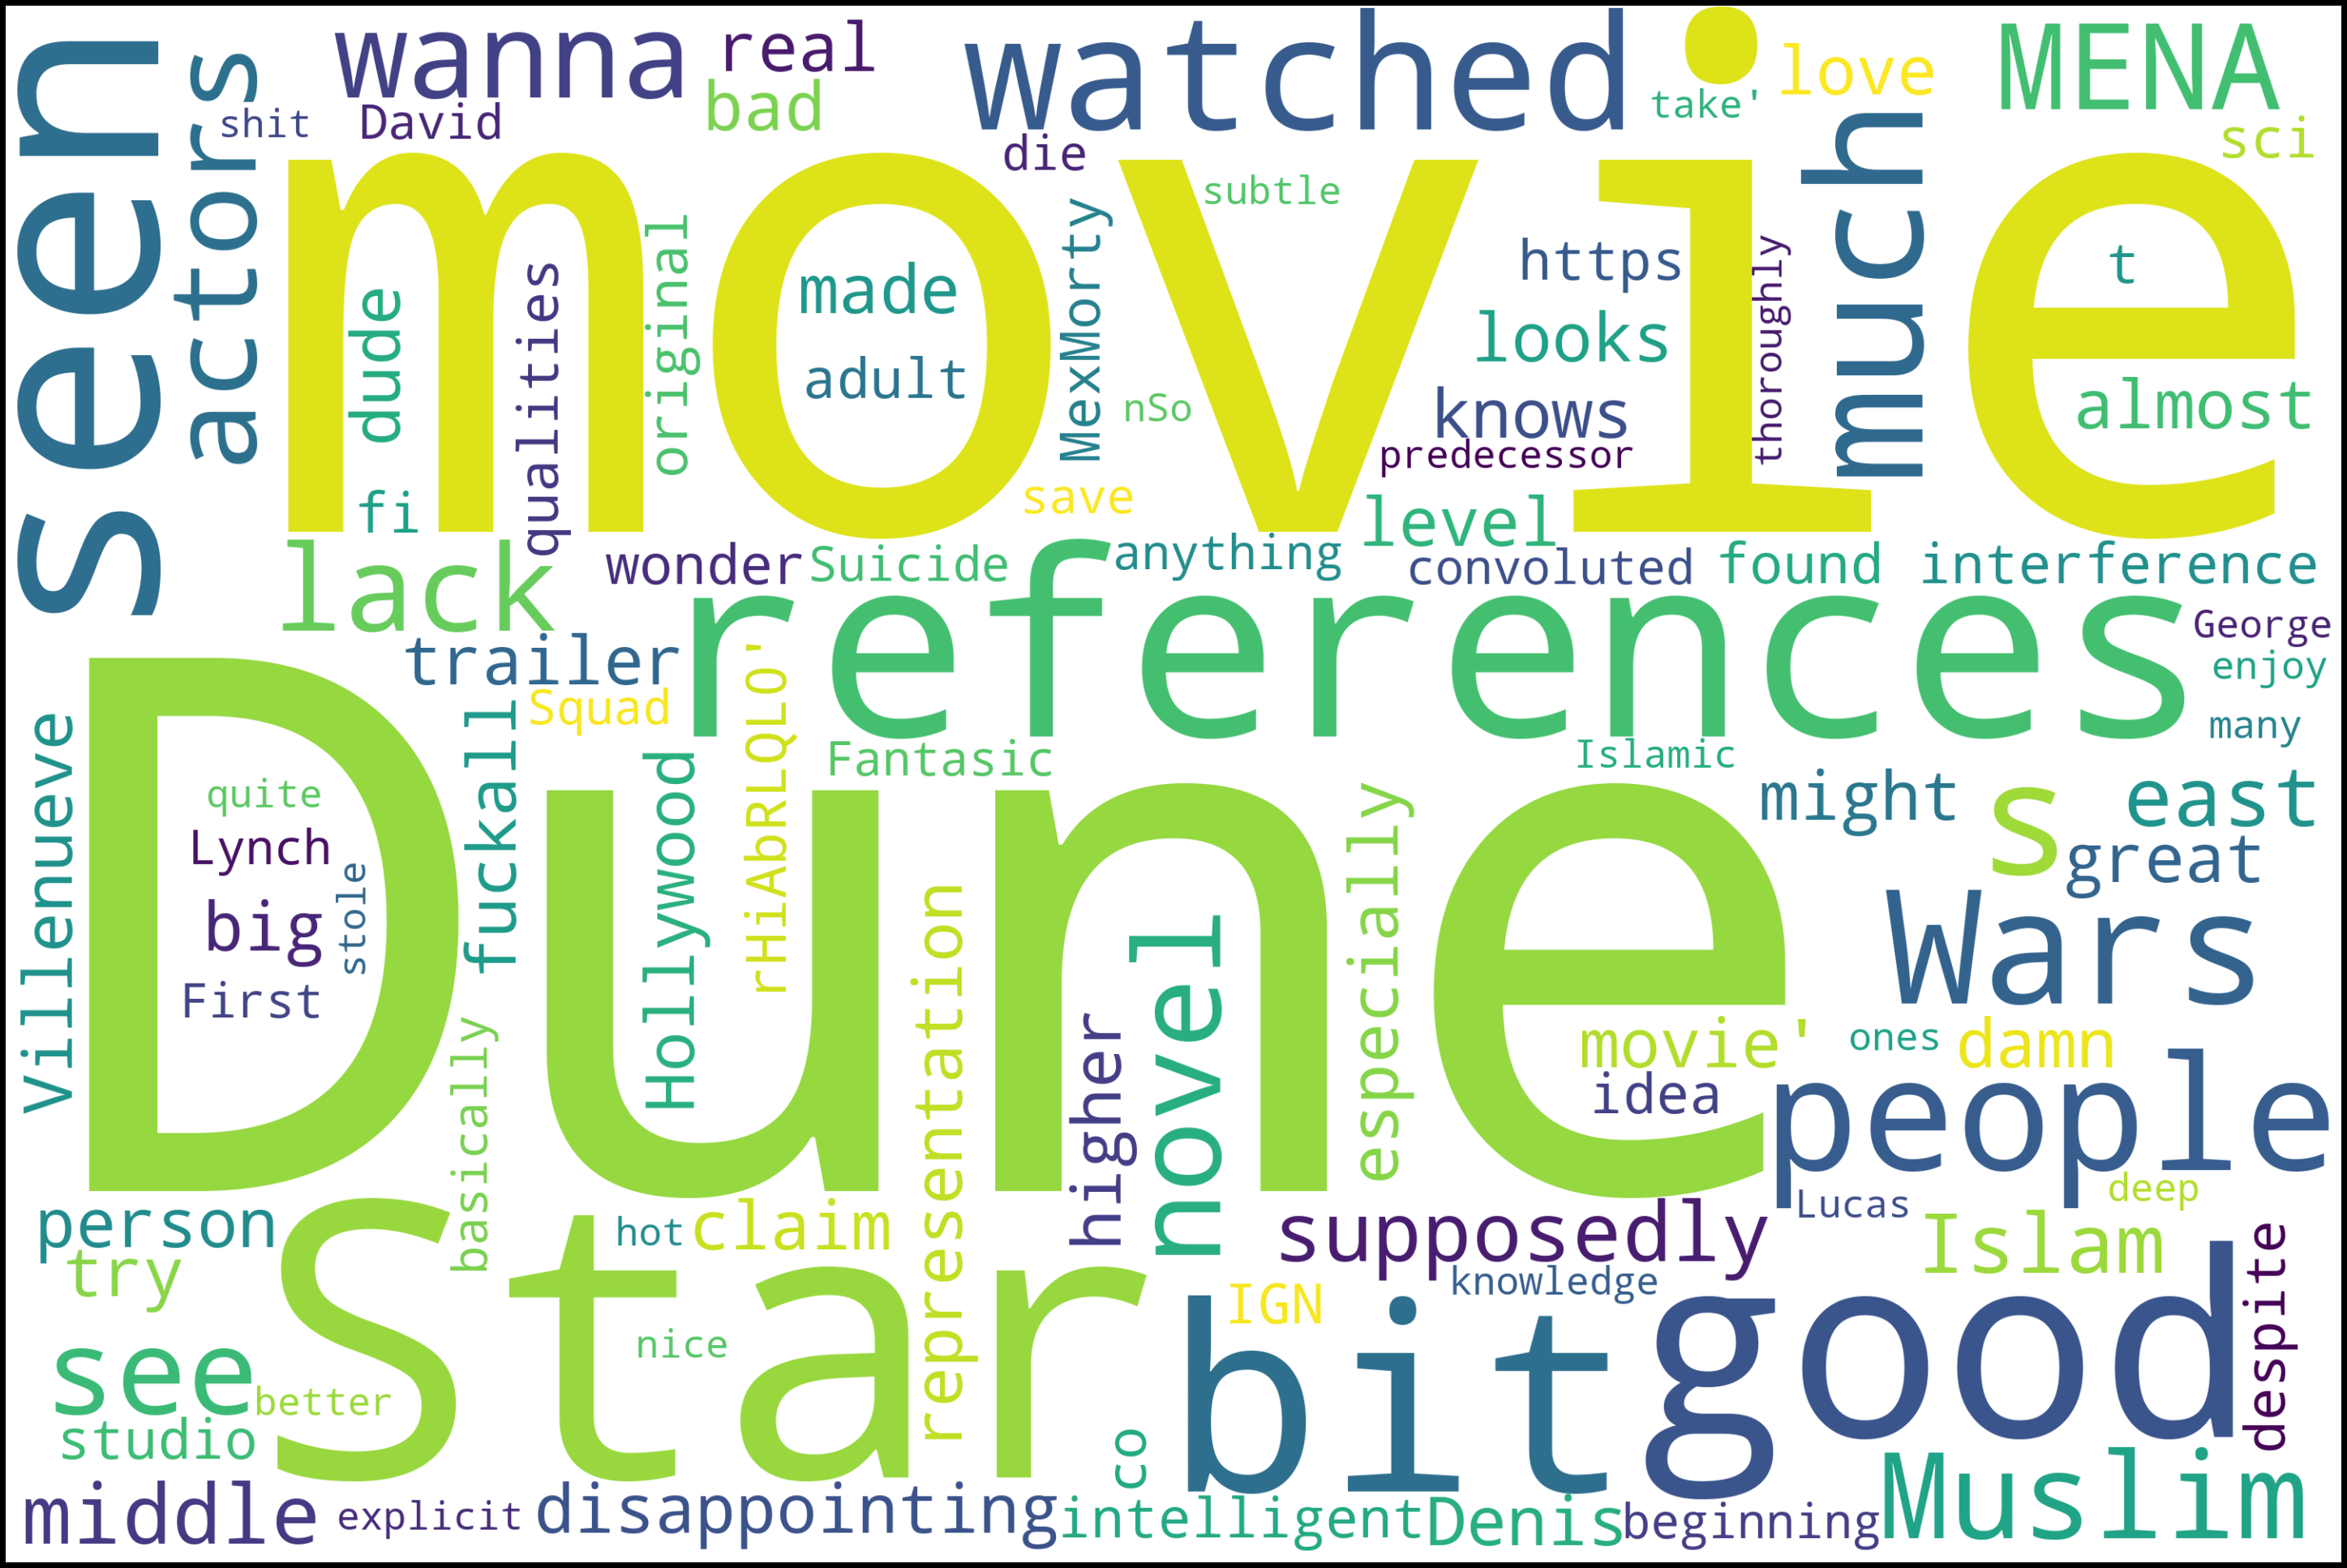

In [15]:
text = tweets_df_dune.Text.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = None).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

On réalise un deuxième wordcloud, pour les tweets concernant le film Space Jam 2

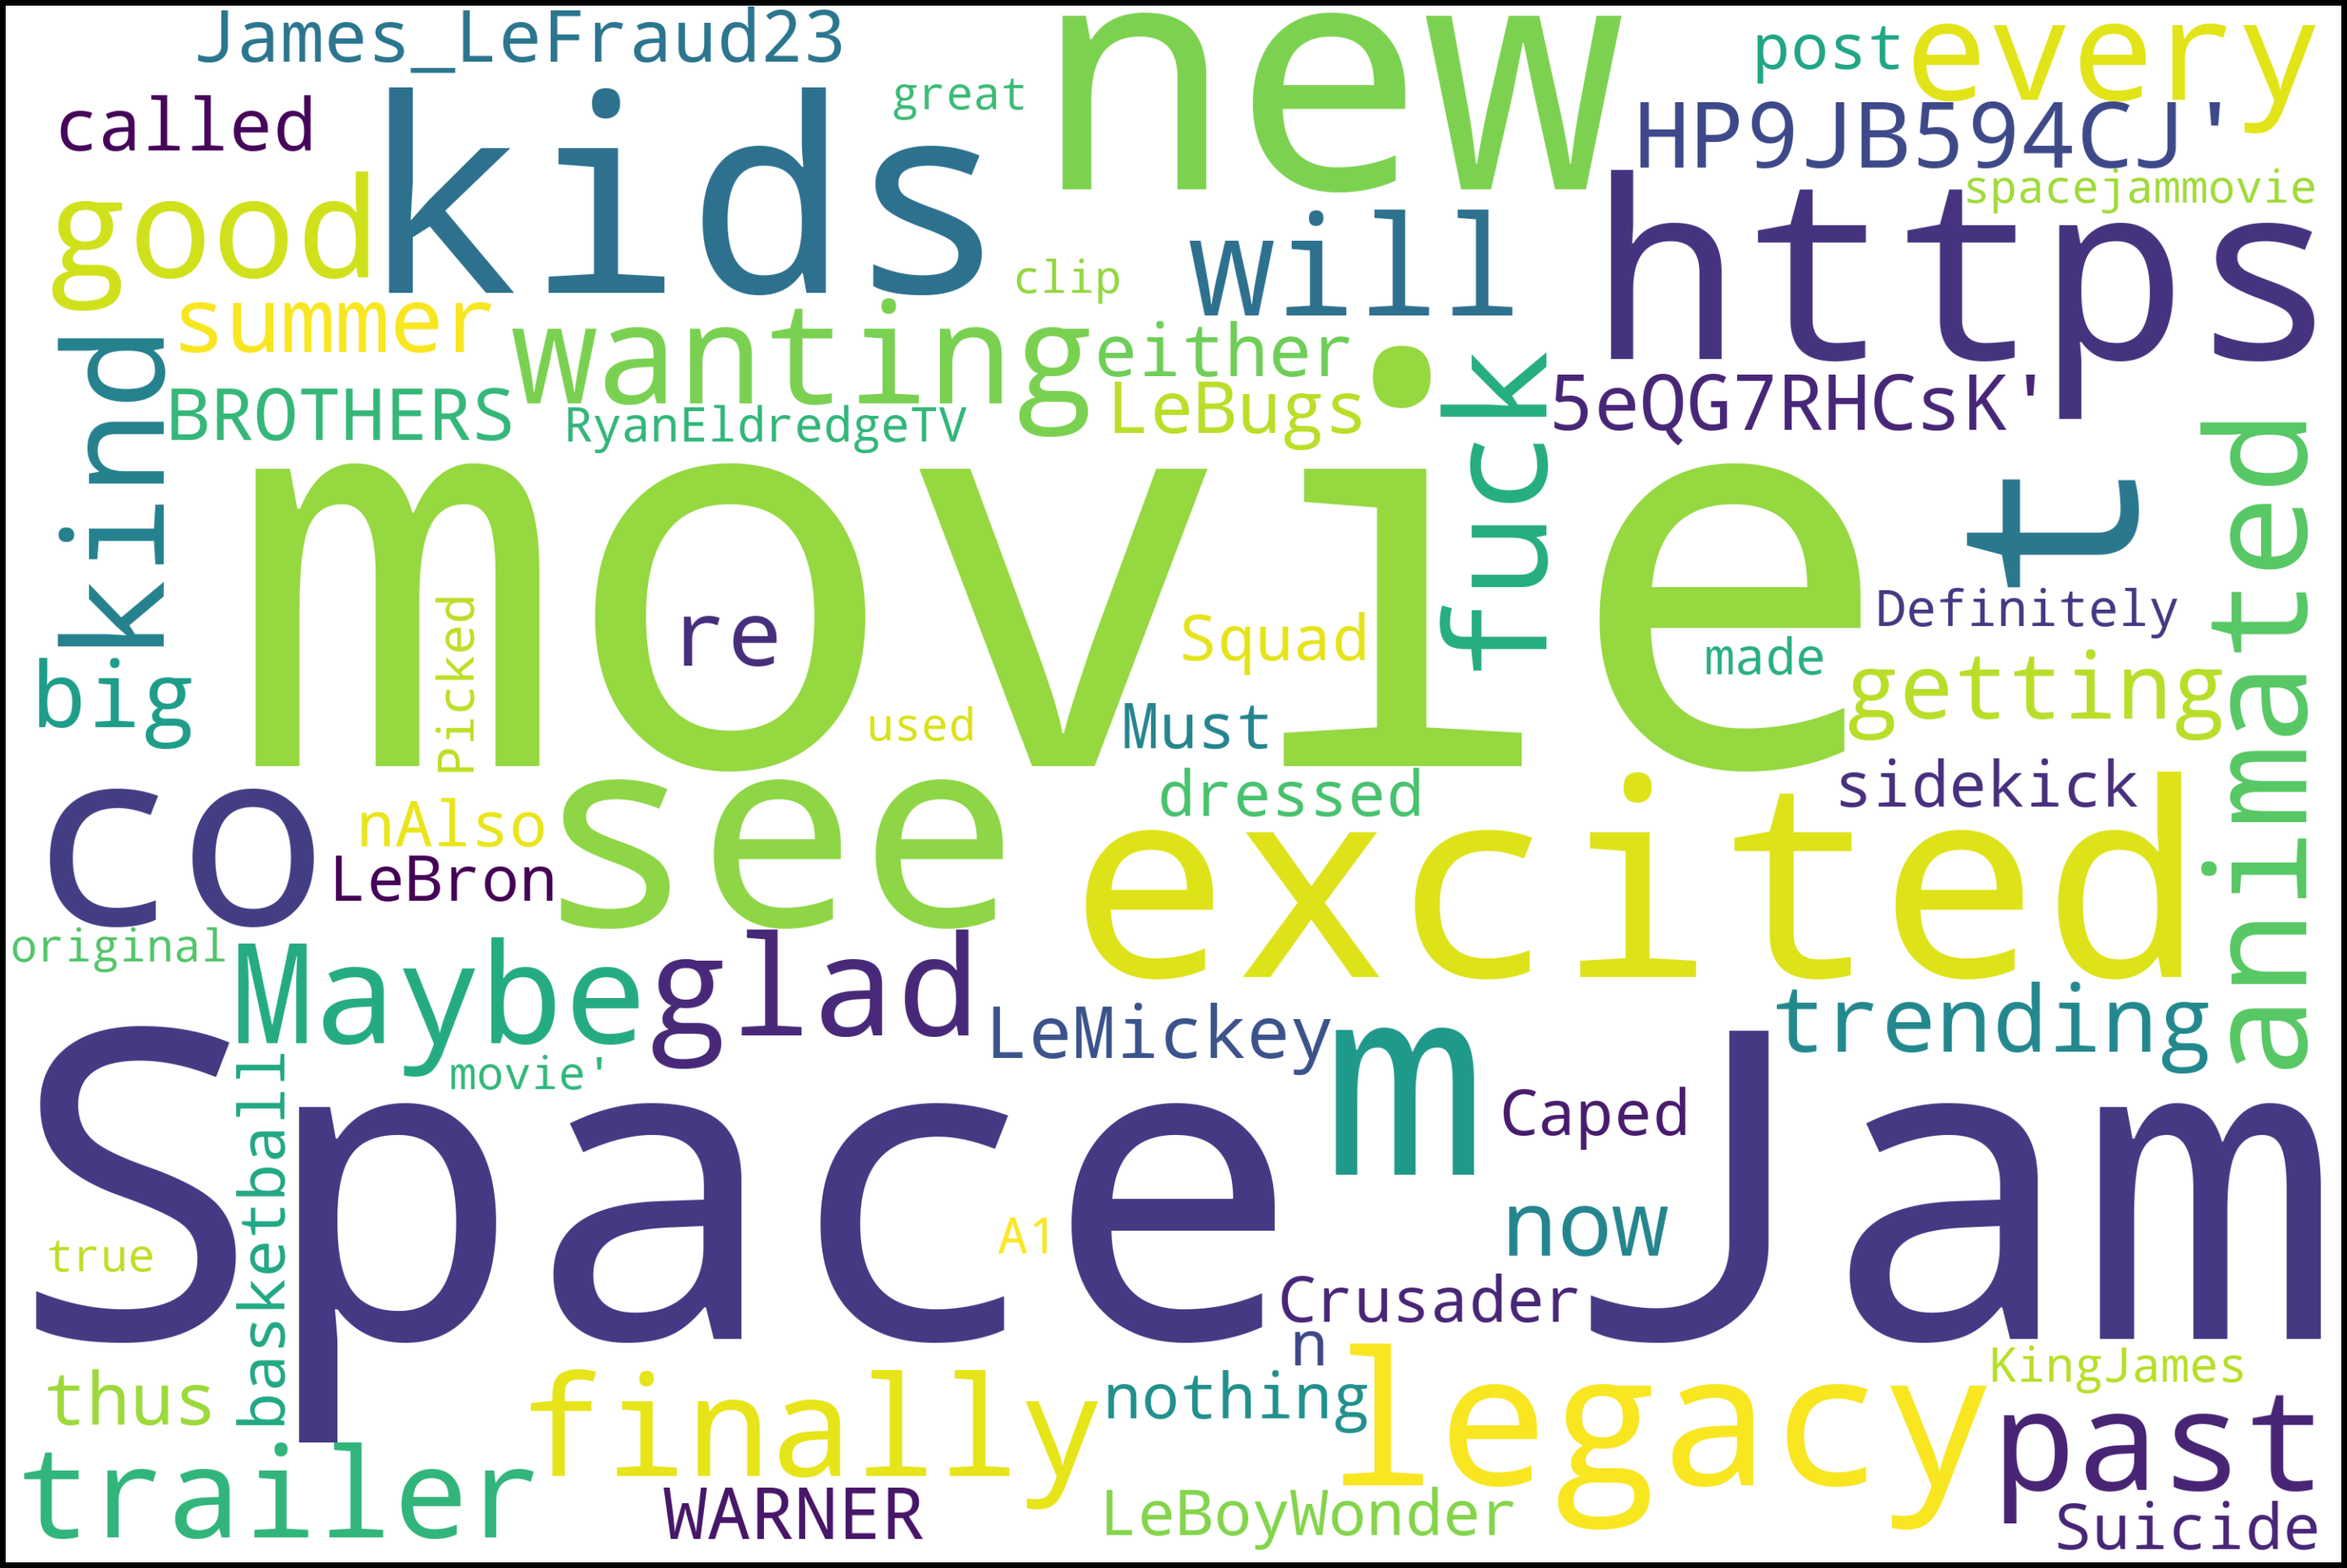

In [16]:
text = tweets_df_space_jam.Text.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = None).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Pour comparer les mots les plus utilisés dans les tweets concernant les deux films d'une manière plus quantitative, on peut utiliser des barplots

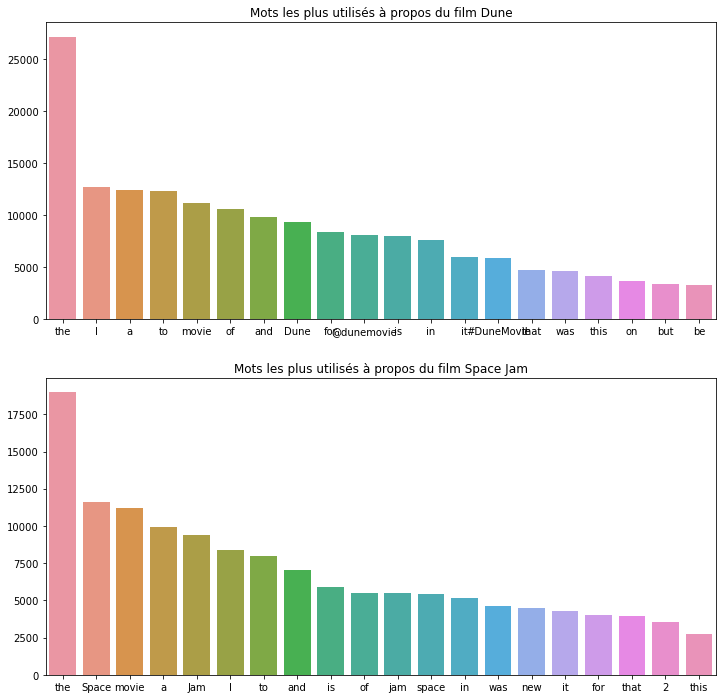

In [17]:
def plot_top_words(Film:str, ax, n_words=20):
    if Film == 'Dune':
      df=tweets_df_dune
    if Film == 'Space Jam':
      df=tweets_df_space_jam
    text = df.Text.values
    all_tokens = ' '.join(text).split()
    counts = Counter(all_tokens)
    top_words = [word[0] for word in counts.most_common(n_words)]
    top_words_counts = [word[1] for word in counts.most_common(n_words)]
    
    # Représentation sous forme de barplot
    ax = sns.barplot(ax = ax, x=top_words, y=top_words_counts)
    ax.set_title(f'Mots les plus utilisés à propos du film {Film}')

fig, axs = plt.subplots(2, 1, figsize = (12,12))

plot_top_words('Dune', ax = axs[0])
plot_top_words('Space Jam', ax = axs[1])

## 3.3 - Préprocessing de la base websrapée

Une ligne de la cellule suivante est volontairement mise en commentaire. Le code avec cette ligne "décommentée" n'a été (et ne doit être) éxécuté qu'une seule fois, pour construire et sauvegarder les différents états de la base de tweets webscrapés, selon que les fonctions stop_words, lemmatization et negation lui ont été appliquées ou non.

Si toutefois, les fichiers devaient être recréés, il faudrait, le cas échéant, être vigilant concernant "l'endroit où les fichiers créés sont sauvegardés sur l'ordinateur".

stop_words: False, lemmatization: False, negation: False, time: 12.448513746261597


,Text
0,i want to see dune but the lack of muslim and mena actors when the novel supposedly references the middle east and islam is disappointing would have been a real good bit of representation for once especially in a big hollywood movie
1,i might be the only person that knows fuckall about dune but damn that trailer looks great and i love denis villenueve that dude has not made a bad movie that i have seen and i have seen almost all of them
2,when people try to claim dune is some higher level intelligent adult sci fi and i wonder if i watched the same movie dune
3,i never read dune but i am v glad you all that did are getting a good movie
4,the mix of styles is really strange the music is not matching the clip or the ambiance almost disgusting me also the casting is not that great i am going to for a movie with such ambition i have that feeling telling me it is going to be an okay movie and not more
5,this movie looks amazing can not wait to watch dunemovie
6,i guess with the dune movie coming out i might need to actually get around to reading dune
7,in honor of the dunetrailer release today dunemovie dune
8,the new trailer it hits some unexpected notes but how to bring it to a new generation of fans pink floyd can not wait for the release
9,king ilysm


stop_words: False, lemmatization: False, negation: True, time: 12.837643146514893


,Text
0,i want to see dune but the lack of muslim and mena actors when the novel supposedly references the middle east and islam is disappointing would have been a real good bit of representation for once especially in a big hollywood movie
1,i might be the only person that knows fuckall about dune but damn that trailer looks great and i love denis villenueve that dude has not_made a bad movie that i have seen and i have seen almost all of them
2,when people try to claim dune is some higher level intelligent adult sci fi and i wonder if i watched the same movie dune
3,i never read dune but i am v glad you all that did are getting a good movie
4,the mix of styles is really strange the music is not_matching the clip or the ambiance almost disgusting me also the casting is not_that great i am going to for a movie with such ambition i have that feeling telling me it is going to be an okay movie and not_more
5,this movie looks amazing can not_wait to watch dunemovie
6,i guess with the dune movie coming out i might need to actually get around to reading dune
7,in honor of the dunetrailer release today dunemovie dune
8,the new trailer it hits some unexpected notes but how to bring it to a new generation of fans pink floyd can not_wait for the release
9,king ilysm


stop_words: False, lemmatization: True, negation: False, time: 122.96678757667542


,Text
0,i want to see dune but the lack of muslim and mena actor when the novel supposedly reference the middle east and islam be disappoint would have be a real good bit of representation for once especially in a big hollywood movie
1,i might be the only person that know fuckall about dune but damn that trailer look great and i love denis villenueve that dude have not make a bad movie that i have see and i have see almost all of them
2,when people try to claim dune be some high level intelligent adult sci fi and i wonder if i watch the same movie dune
3,i never read dune but i be v glad you all that do be get a good movie
4,the mix of style be really strange the music be not match the clip or the ambiance almost disgust me also the casting be not that great i be go to for a movie with such ambition i have that feeling tell me it be go to be an okay movie and not more
5,this movie look amaze can not wait to watch dunemovie
6,i guess with the dune movie come out i might need to actually get around to read dune
7,in honor of the dunetrailer release today dunemovie dune
8,the new trailer it hit some unexpected note but how to bring it to a new generation of fan pink floyd can not wait for the release
9,king ilysm


stop_words: False, lemmatization: True, negation: True, time: 120.07879447937012


,Text
0,i want to see dune but the lack of muslim and mena actor when the novel supposedly reference the middle east and islam be disappoint would have be a real good bit of representation for once especially in a big hollywood movie
1,i might be the only person that know fuckall about dune but damn that trailer look great and i love denis villenueve that dude have not_make a bad movie that i have see and i have see almost all of them
2,when people try to claim dune be some high level intelligent adult sci fi and i wonder if i watch the same movie dune
3,i never read dune but i be v glad you all that do be get a good movie
4,the mix of style be really strange the music be not_match the clip or the ambiance almost disgust me also the casting be not_that great i be go to for a movie with such ambition i have that feeling tell me it be go to be an okay movie and not_more
5,this movie look amaze can not_wait to watch dunemovie
6,i guess with the dune movie come out i might need to actually get around to read dune
7,in honor of the dunetrailer release today dunemovie dune
8,the new trailer it hit some unexpected note but how to bring it to a new generation of fan pink floyd can not_wait for the release
9,king ilysm


stop_words: True, lemmatization: False, negation: False, time: 11.759710311889648


,Text
0,want see dune lack muslim mena actors novel supposedly references middle east islam disappointing would real good bit representation especially big hollywood movie
1,might person knows fuckall dune damn trailer looks great love denis villenueve dude not made bad movie seen seen almost
2,people try claim dune higher level intelligent adult sci fi wonder watched movie dune
3,never read dune v glad getting good movie
4,mix styles really strange music not matching clip ambiance almost disgusting also casting not great going movie ambition feeling telling going okay movie not
5,movie looks amazing not wait watch dunemovie
6,guess dune movie coming might need actually get around reading dune
7,honor dunetrailer release today dunemovie dune
8,new trailer hits unexpected notes bring new generation fans pink floyd not wait release
9,king ilysm


stop_words: True, lemmatization: False, negation: True, time: 13.158181190490723


,Text
0,want see dune lack muslim mena actors novel supposedly references middle east islam disappointing would real good bit representation especially big hollywood movie
1,might person knows fuckall dune damn trailer looks great love denis villenueve dude not_made bad movie seen seen almost
2,people try claim dune higher level intelligent adult sci fi wonder watched movie dune
3,never read dune v glad getting good movie
4,mix styles really strange music not_matching clip ambiance almost disgusting also casting not_great going movie ambition feeling telling going okay movie not
5,movie looks amazing not_wait watch dunemovie
6,guess dune movie coming might need actually get around reading dune
7,honor dunetrailer release today dunemovie dune
8,new trailer hits unexpected notes bring new generation fans pink floyd not_wait release
9,king ilysm


stop_words: True, lemmatization: True, negation: False, time: 105.35295939445496


,Text
0,want see dune lack muslim mena actor novel supposedly reference middle east islam disappoint would real good bit representation especially big hollywood movie
1,might person know fuckall dune damn trailer look great love denis villenueve dude not make bad movie see see almost
2,people try claim dune high level intelligent adult sci fi wonder watch movie dune
3,never read dune v glad get good movie
4,mix style really strange music not match clip ambiance almost disgust also cast not great go movie ambition feel tell go okay movie not
5,movie look amaze not wait watch dunemovie
6,guess dune movie come might need actually get around read dune
7,honor dunetrailer release today dunemovie dune
8,new trailer hit unexpected note bring new generation fan pink floyd not wait release
9,king ilysm


stop_words: True, lemmatization: True, negation: True, time: 106.78939247131348


,Text
0,want see dune lack muslim mena actor novel supposedly reference middle east islam disappoint would real good bit representation especially big hollywood movie
1,might person know fuckall dune damn trailer look great love denis villenueve dude not_make bad movie see see almost
2,people try claim dune high level intelligent adult sci fi wonder watch movie dune
3,never read dune v glad get good movie
4,mix style really strange music not_match clip ambiance almost disgust also cast not_great go movie ambition feel tell go okay movie not
5,movie look amaze not_wait watch dunemovie
6,guess dune movie come might need actually get around read dune
7,honor dunetrailer release today dunemovie dune
8,new trailer hit unexpected note bring new generation fan pink floyd not_wait release
9,king ilysm


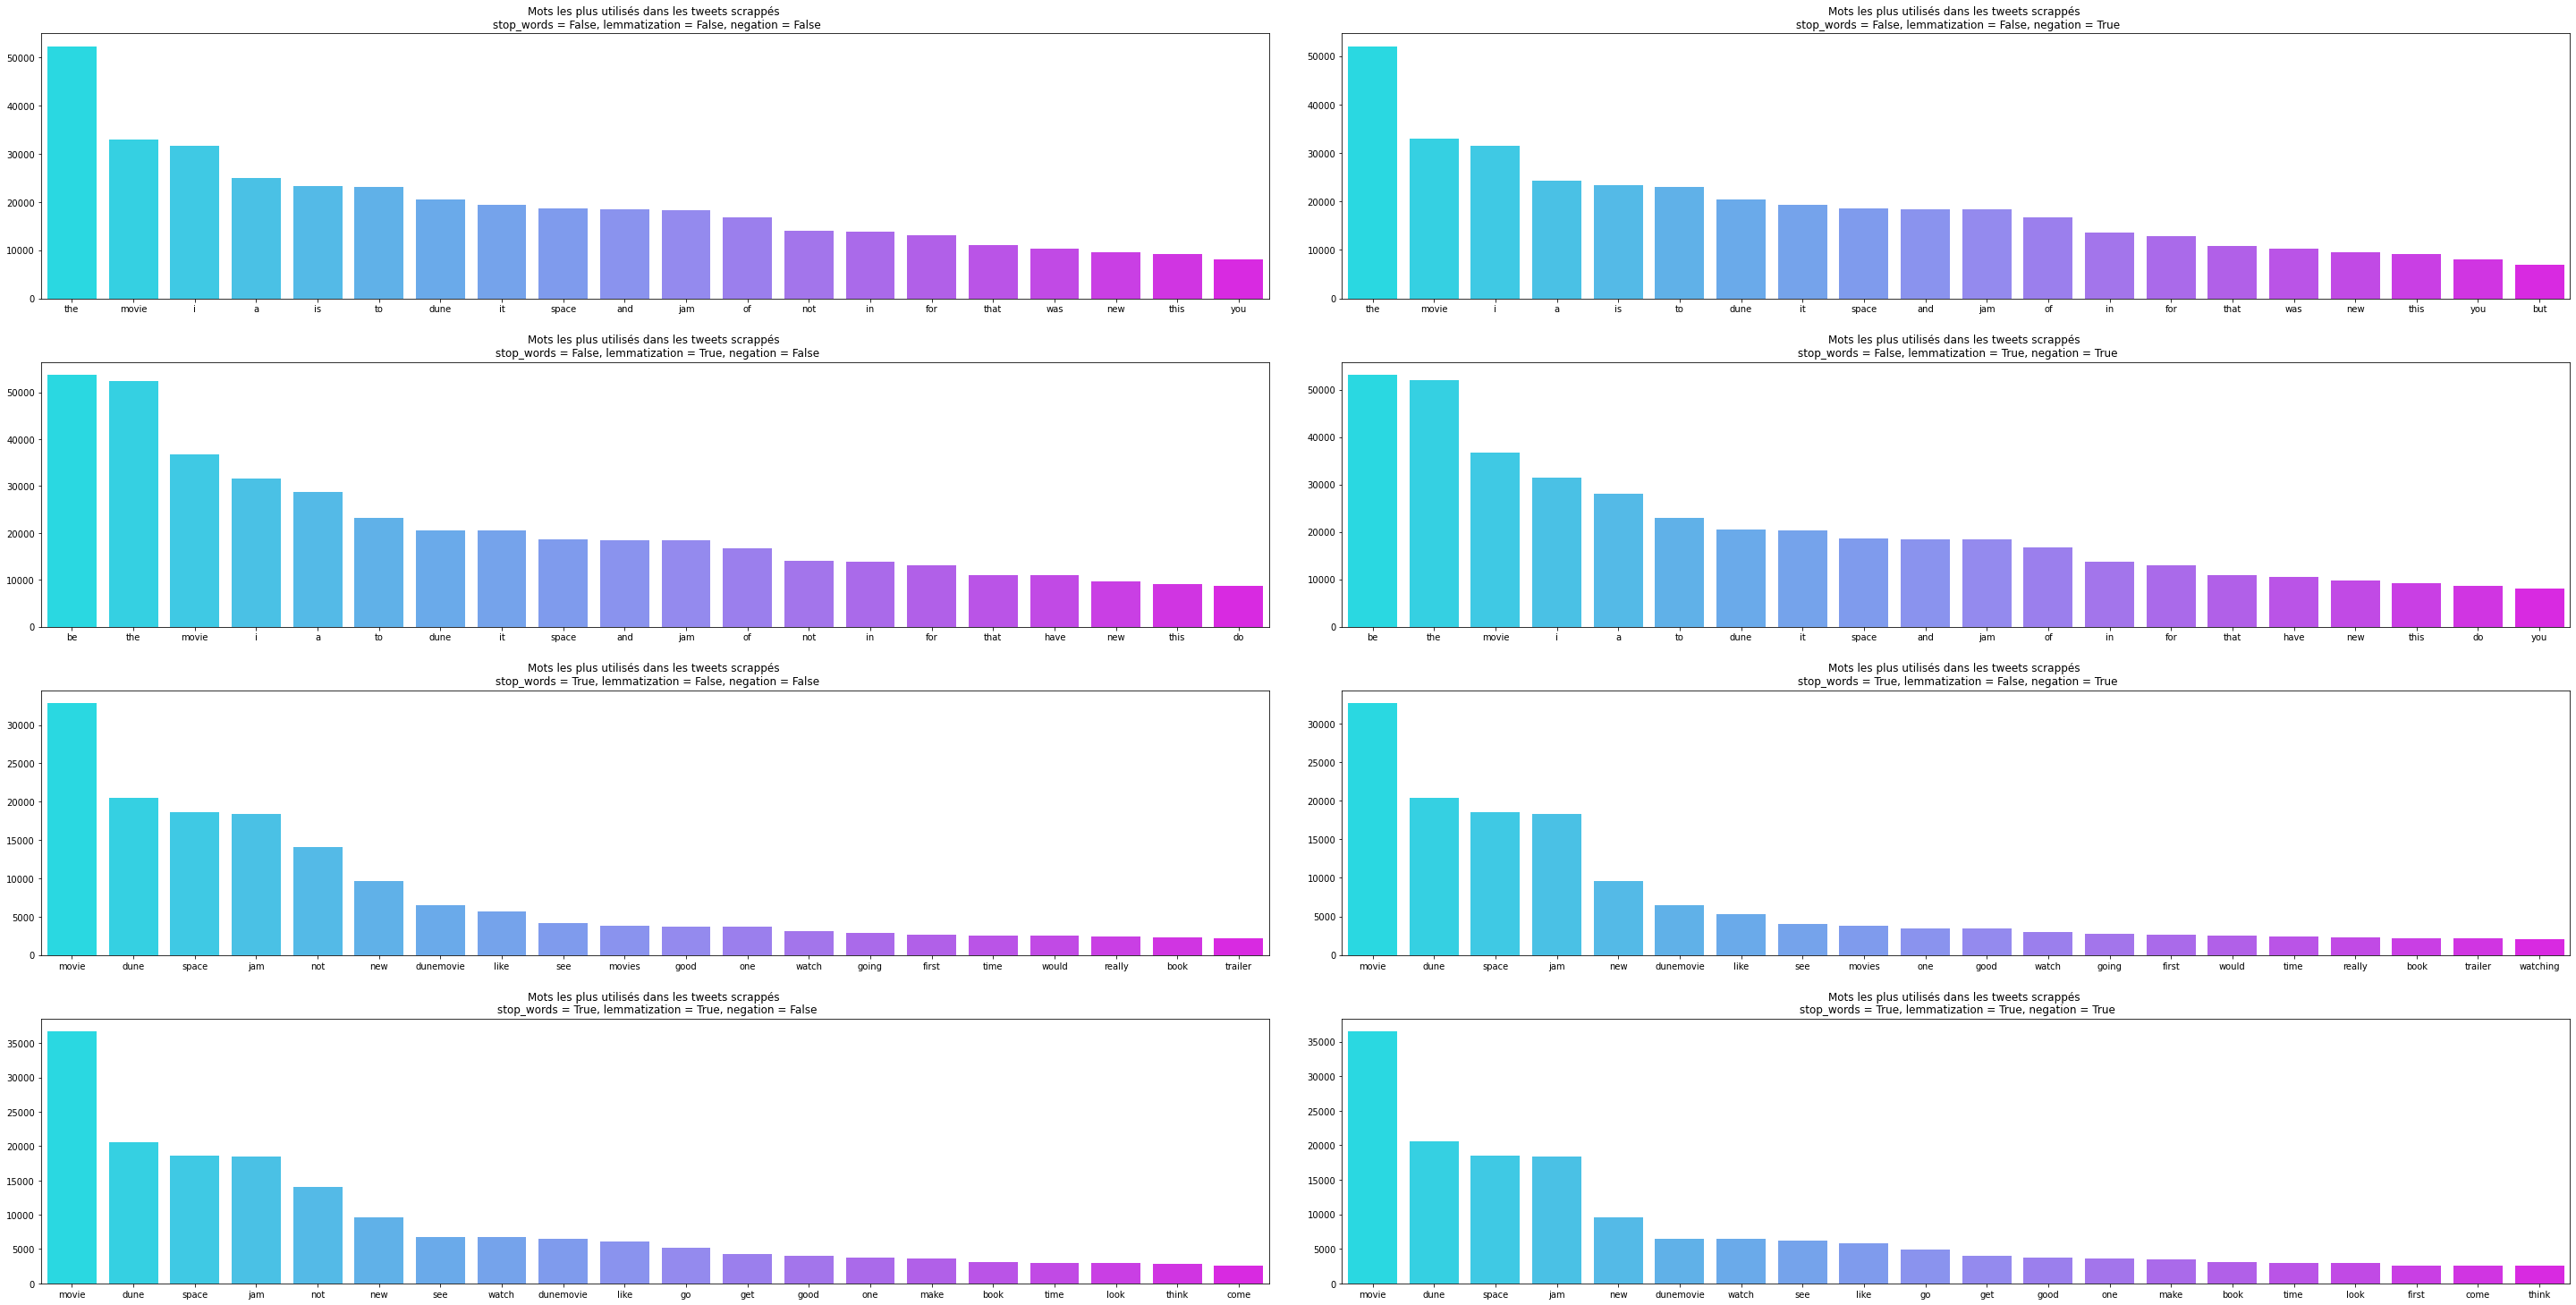

In [18]:
fig, axs  = plt.subplots(4,2, figsize=(40,20))
fig.tight_layout(h_pad=5, w_pad=5)
axs= np.array(axs).flatten()
i=0
for stop_words in [False, True]:
    for lemmatization in [False, True]:
        for negation in [False, True]:
            dfcopy = tweets_df.copy()
            a = time.time()
            dfcopy.Text = text_preprocessing(dfcopy.Text, stop_words=stop_words, lemmatization=lemmatization, negation=negation)
            dfcopy = dfcopy[dfcopy.Text != '']

            print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}, time: {time.time() - a}")
            display(dfcopy[['Text']].head(10))
            text = dfcopy.Text.values
            all_tokens = ' '.join(text).split()
            counts = Counter(all_tokens)
            top_words = [word[0] for word in counts.most_common(20)]
            top_words_counts = [word[1] for word in counts.most_common(20)]
            ax = sns.barplot(ax=axs[i], x=top_words, y=top_words_counts, palette='cool')
            i=i+1
            ax.set_title(f'Mots les plus utilisés dans les tweets scrappés \n stop_words = {stop_words}, lemmatization = {lemmatization}, negation = {negation}')

            file = "web"
            if stop_words:
                file += "_stop"
            if lemmatization:
                file += "_lemm"
            if negation:
                file += "_neg"
            #dfcopy.to_pickle(os.path.join("data", "web", file + ".csv"))

plt.show()

Les différences entre les résultats donnés par les différentes combinaisons d’arguments de preprocessing (stop_words, lemmatization, negation) ne semblent pas flagrantes. 

Pour déterminer la meilleure combinaison, il va donc falloir procéder à des tests plus poussés. En l’occurrence, nous allons appliquer trois modèles d’apprentissage combinés à différentes méthodes de "feature extraction" à chacune des huit versions préprocessées de la base Sentiment140, et comparer les résultats obtenus pour déterminer la combinaison la plus performante.